In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
from scipy.io import loadmat
import scipy.linalg as linalg
import numpy as np
from scipy.stats.kde import gaussian_kde
from sklearn.neighbors import NearestNeighbors


Let's load the data

In [2]:
df = pd.read_csv('OurDatabase.csv')


Let's see column names

In [3]:
df.columns

Index(['Unnamed: 0', 'Time', 'Time Code', 'Country Name', 'Country Code',
       'Fertility rate', 'Life expectancy', 'Unemployment', 'GDP per capita',
       'Population growth', 'Alcohol per capita', 'Suicide mortality rate',
       'PM2.5 air pollution', 'Population density', 'Military expenditure',
       'Terrorism Index', 'Happiness Score', 'isDevelopedEconomy',
       'Continent'],
      dtype='object')

Let's actually see the data

In [4]:
df

,Unnamed: 0,Time,Time Code,Country Name,Country Code,Fertility rate,Life expectancy,Unemployment,GDP per capita,Population growth,Alcohol per capita,Suicide mortality rate,PM2.5 air pollution,Population density,Military expenditure,Terrorism Index,Happiness Score,isDevelopedEconomy,Continent
0,0,2015,YR2015,Afghanistan,AFG,4.802,63.298195,8.600000,599.135196,2.943234,1.0,5.5,48.016765,51.674929,0.993454,9.233,3.575,n,Asia
1,1,2015,YR2015,Albania,ALB,1.714,78.203146,17.100000,4524.990993,-0.291206,6.6,4.3,17.936625,105.135146,1.167601,2.116,4.959,n,Europe
2,2,2015,YR2015,Algeria,DZA,2.839,75.855293,11.200000,4759.595242,1.919959,0.6,3.1,35.564533,16.740504,6.274210,4.750,5.605,n,Africa
3,3,2015,YR2015,Angola,AGO,5.766,61.189341,6.200000,3730.169063,3.428021,7.6,20.5,36.395428,22.346439,3.515939,0.243,4.033,n,Africa
4,4,2015,YR2015,Argentina,ARG,2.308,76.293024,7.200000,10490.019568,1.009855,7.6,14.2,13.443965,15.865065,0.864723,1.674,6.574,n,South America
5,5,2015,YR2015,Armenia,ARM,1.622,74.206195,18.299999,3935.288772,0.368528,5.5,5.4,25.507685,102.456972,4.239226,0.115,4.350,n,Europe
6,6,2015,YR2015,Australia,AUS,1.833,82.451220,6.100000,54941.911458,1.391107,12.6,11.8,5.897735,3.096643,1.978861,3.114,7.284,d,Oceania
7,7,2015,YR2015,Austria,AUT,1.470,81.843902,5.700000,47834.787303,1.066623,8.5,16.4,17.012994,104.615307,0.664019,2.088,7.200,d,Europe
8,8,2015,YR2015,Azerbaijan,AZE,1.970,71.845195,5.000000,6117.030862,1.191210,2.1,3.3,30.354013,116.731077,5.608680,1.381,5.212,n,Europe
9,9,2015,YR2015,Bahrain,BHR,2.056,76.865195,1.100000,22436.207532,2.618665,2.4,6.5,55.454352,1779.319066,4.592714,4.871,5.960,n,Asia


# Creating X

In [5]:
countryNames = list(df['Country Name'])
l = list(df.columns)
attributesToShow = l[5:-2]
X = df.as_matrix(columns = attributesToShow)
N = len(df)
X.shape


(129, 12)

Let's standirdize our X matrix

In [6]:
stdVector = np.array(df[attributesToShow].std())
stdVector = np.expand_dims(stdVector,axis = 0)
X = X / stdVector
X = X - np.ones((N,1))*X.mean(0)

# Gaussian Kernel density

In [7]:
# Compute kernel density estimate
kde = gaussian_kde(X.T)

The index of the lowest density object: 104


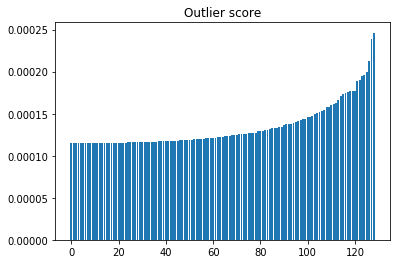

In [8]:
scores = kde.evaluate(X.T)
idx = scores.argsort()
scores.sort()

print('The index of the lowest density object: {0}'.format(idx[0]))

# Plot kernel density estimate
plt.figure()
plt.bar(range(len(X)),scores)
plt.title('Outlier score')
plt.show()


In [9]:
g = df.columns.to_series().groupby(df.dtypes).groups
rankableColumns = {k.name: v for k, v in g.items()}['float64']
rankColumns = []
for c in rankableColumns:
    cR = c + '_rank'
    rankColumns.append(cR)
    df[cR] = df[c].rank(ascending = False)
    df[cR] = df[cR].astype(int)

In [10]:
outlierCountries = set()

for i in idx[:5]:
    print(countryNames[i])
    outlierCountries.add(countryNames[i])




Singapore
Saudi Arabia
Oman
Lebanon
Kuwait


# KNN density

In [11]:
# Number of neighbors
K = 5

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)




Just for fun let's see the countries which are closest to Denmark 

In [12]:
D, i = knn.kneighbors(np.matrix(list(X)[32]))
for j in i.ravel():
    print(countryNames[j])


Denmark
Netherlands
Canada
Switzerland
Finland


Let's do the density estimation 


In [13]:
D, i = knn.kneighbors(X)

In [14]:
# Compute the density
#D, i = knclassifier.kneighbors(np.matrix(xe).T)
knn_density = 1./(D.sum(axis=1)/K)
# Compute the average relative density
DX, iX = knn.kneighbors(X)
knn_densityX = 1./(DX[:,1:].sum(axis=1)/K)
knn_avg_rel_density = knn_density/(knn_densityX[i[:,1:]].sum(axis=1)/K)
scores = knn_densityX

The index of the lowest density object: 104


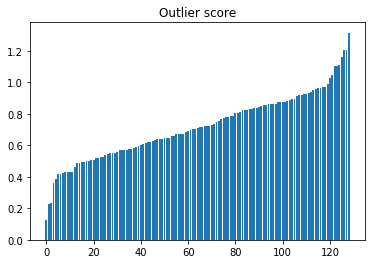

In [15]:
idx = scores.argsort()
scores.sort()

print('The index of the lowest density object: {0}'.format(idx[0]))

# Plot kernel density estimate
plt.figure()
plt.bar(range(129),scores[:129])
plt.title('Outlier score')
plt.show()



In [16]:
for i in idx[:5]:
    print(countryNames[i])
    outlierCountries.add(countryNames[i])


Singapore
Oman
Saudi Arabia
Kuwait
Bahrain


# KNN average relative density 

In [17]:
knn_avg_rel_density = knn_density/(knn_densityX[iX[:,1:]].sum(axis=1)/K)
scores = knn_avg_rel_density



The index of the lowest density object: 104


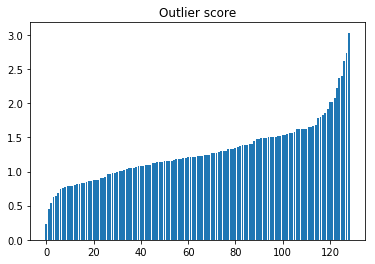

In [18]:
idx = scores.argsort()
scores.sort()

print('The index of the lowest density object: {0}'.format(idx[0]))

# Plot kernel density estimate
plt.figure()
plt.bar(range(129),scores[:])
plt.title('Outlier score')
plt.show()


In [19]:
for i in idx[:5]:
    print(countryNames[i])
    outlierCountries.add(countryNames[i])

Singapore
Oman
Saudi Arabia
Mauritania
Mozambique


In [20]:
df[df['Country Name'].isin(outlierCountries)][ ['Country Name'] + rankColumns ]


,Country Name,Fertility rate_rank,Life expectancy_rank,Unemployment_rank,GDP per capita_rank,Population growth_rank,Alcohol per capita_rank,Suicide mortality rate_rank,PM2.5 air pollution_rank,Population density_rank,Military expenditure_rank,Terrorism Index_rank,Happiness Score_rank
9,Bahrain,68,39,124,29,24,101,86,12,2,9,24,40
62,Kuwait,75,61,111,20,3,128,114,7,24,8,102,32
65,Lebanon,91,28,71,58,2,103,122,40,6,10,14,84
75,Mauritania,17,107,36,103,18,128,96,4,125,22,91,102
82,Mozambique,8,120,4,123,17,107,73,85,99,98,30,76
90,Oman,45,37,15,34,1,115,100,14,119,1,116,19
100,Saudi Arabia,48,63,80,31,29,125,118,1,116,2,36,29
104,Singapore,127,6,122,8,67,97,60,89,1,20,116,20
